<a href="https://colab.research.google.com/github/aazmhafidz09/CNN-untuk-pelafalan-quran/blob/main/Hijaiyyah_Klassification_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import librosa
import librosa.feature 
import librosa.display
import glob 
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation 
from keras.utils.np_utils import to_categorical 
import tensorflow as tf
from google.colab import files

# Access Kaggle API

Upload kaggle api key

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aazmhafidzazis","key":"b248585ad517defa6ec37289d6b03a0f"}'}

# Dataset Preparation

Download and unzipping dataset

In [3]:
!pip install --upgrade kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d aazmhafidzazis/kasrahhijaiyahaudio
! mkdir dataset_final
! unzip /content/kasrahhijaiyahaudio.zip -d dataset_final

letters_path = '/content/dataset_final/Dataset - Filter -  Fix/'
print(letters_path)


     |████████████████████████████████| 61kB 5.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=f2add99d84669f7062f75ec54b1b9b4a49a3e5572d48847eb4a14e8bf23314f6
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
100% 253M/254M [00:03<00:00, 97.0MB/s]
100% 254M/254M [00:03<00:00, 88.0MB/s]
Archive:  /content/kasrahhijaiyahaudio.zip
  inflating: dataset_final/Dataset - Filter -  Fix/.png  
  inflating: dataset_final/Dataset - Filter -  Fix/1. I/Ponpes At Taufiq F.1-01.wav  
  inflating: dataset_final/Dataset - Filter -  Fix/1. I/Ponpes At Taufiq F.1-02.wav  
  inflating: dataset_final/Dataset - Filter -  Fix/1. I/Ponpes At Taufiq F.1-03.wav  
  inflating: dataset_final/Dataset - Filter -  Fix/1. I/Ponpes At Taufiq F.1-04.wav  
  inflating: dat

**Dataset preprocessing**

MFCC

In [4]:
def display_mfcc(voice):
   y, _ = librosa.load(voice)
   mfcc = librosa.feature.mfcc(y)

   plt.figure(figsize=(10, 4))
   librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
   plt.colorbar()
   plt.title(voice)
   plt.tight_layout()
   plt.show()

def extract_features_letter(voice):
    y, _ = librosa.load(voice)
    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y, n_mfcc=40)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))

    return np.ndarray.flatten(mfcc)[:800]

def generate_features_and_labels():
    '''
    Produce MFCC values and letter names 
    from all the songs in the dataset
    '''
    
    # Prepare a list for all the features and all the labels
    all_features = []
    all_labels = []
    letters = ['1. I', '2. Bi', '3. Ti', '4. Tsi', '5. Ji' ,
              '6. hi', '7. Khi', '8. Di', '9. Dzi', '10. Ri' ,
              '11. Dzi', '12. Si','13. Syi','14. Shi','15. Dhi',
              '16. Thi','17. Dzhi',"18. I",'19. Ghi','20. fi',
              '21. Qi','22. ki','23. li','24. mi','25. ni','26. wi','27. Hi','28. Yi' ]
#    
    print('Total Huruf ', len(letters))

    # Extract features and letter names from each voice
    for letter in letters:
        voice_files = glob.glob(letters_path + letter + '/*.wav')
        print('Processing %d letters in %s voice letter...' % (len(voice_files), letter))
        for f in voice_files :
                features = extract_features_letter(f)
                all_features.append(features)
                all_labels.append(letter)
            
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse= True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids,  len(label_uniq_ids))
    
    return np.stack(all_features), onehot_labels

Generate features and labels using MFCC

In [5]:
features, labels = generate_features_and_labels()

Total Huruf  28
Processing 114 letters in 1. I voice letter...
Processing 113 letters in 2. Bi voice letter...
Processing 103 letters in 3. Ti voice letter...
Processing 94 letters in 4. Tsi voice letter...
Processing 107 letters in 5. Ji voice letter...
Processing 109 letters in 6. hi voice letter...
Processing 109 letters in 7. Khi voice letter...
Processing 106 letters in 8. Di voice letter...
Processing 106 letters in 9. Dzi voice letter...
Processing 108 letters in 10. Ri voice letter...
Processing 101 letters in 11. Dzi voice letter...
Processing 108 letters in 12. Si voice letter...
Processing 112 letters in 13. Syi voice letter...
Processing 98 letters in 14. Shi voice letter...
Processing 107 letters in 15. Dhi voice letter...
Processing 110 letters in 16. Thi voice letter...
Processing 109 letters in 17. Dzhi voice letter...
Processing 109 letters in 18. I voice letter...
Processing 106 letters in 19. Ghi voice letter...
Processing 109 letters in 20. fi voice letter...
Proces

Display result of dataset preparation

In [6]:
from sklearn import preprocessing

x = features
y = labels

min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(x)

Splitting data training and testing

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scale, y, test_size = 0.2)

X_train = tf.expand_dims(X_train, axis=-1)

X_test = tf.expand_dims(X_test, axis=-1)

# Making CNN Model

Setting model parameter

In [18]:
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=epochs, 
                     batch_size=batch_size)

Model training

In [17]:
model_1 = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(800,1)),
      tf.keras.layers.AveragePooling1D(pool_size=2),
      # tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', ),
      tf.keras.layers.AveragePooling1D(pool_size=2),
      tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu',),
      tf.keras.layers.AveragePooling1D(pool_size=2),
      # tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv1D(filters=512, kernel_size=3, activation='relu',),
      tf.keras.layers.AveragePooling1D(pool_size=2),
      # tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Conv1D(filters=512, kernel_size=3, activation='relu',),
      tf.keras.layers.AveragePooling1D(pool_size=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100, activation='relu'),
      # tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(28, activation='softmax'),                              
])

model.summary()
model_history = trainModel(model=model_1, epochs=100, optimizer='rmsprop')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 798, 64)           256       
_________________________________________________________________
average_pooling1d_14 (Averag (None, 399, 64)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 397, 128)          24704     
_________________________________________________________________
average_pooling1d_15 (Averag (None, 198, 128)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 196, 256)          98560     
_________________________________________________________________
average_pooling1d_16 (Averag (None, 98, 256)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 96, 512)          

KeyboardInterrupt: ignored

Model result

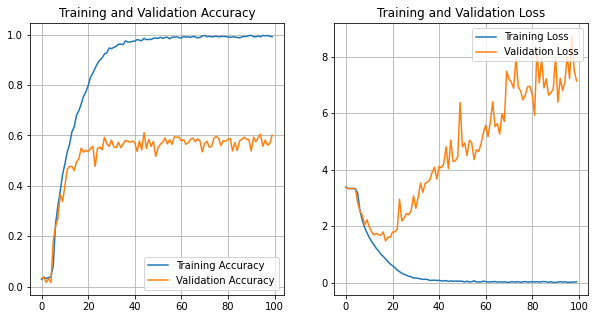

In [13]:
import matplotlib.pyplot as plt
def plot_hist(history):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()

plot_hist(model_history)


In [14]:
 model.evaluate(
    X_test,
    Y_test,
)

19/19 [==============================] - 0s 12ms/step - loss: 7.1301 - accuracy: 0.6010


[7.130092144012451, 0.6009933948516846]

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
y_pred = (predictions > 0.5)

matrix = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0],
       [17,  9,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  0, 15,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  2],
       [ 6,  0,  0, 17,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [13,  0,  0,  0,  0,  0,  5,  0,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 8,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  1,  0,  2,  1,  0,
         0,  0,  0,  0,  

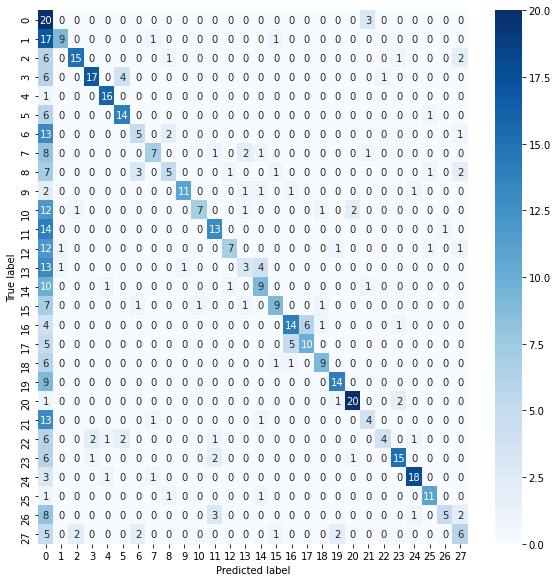

In [ ]:
import seaborn as sns

figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print (classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65        23
           1       0.82      0.32      0.46        28
           2       0.83      0.60      0.70        25
           3       0.85      0.61      0.71        28
           4       0.84      0.94      0.89        17
           5       0.70      0.67      0.68        21
           6       0.45      0.24      0.31        21
           7       0.70      0.35      0.47        20
           8       0.56      0.25      0.34        20
           9       0.92      0.65      0.76        17
          10       0.88      0.29      0.44        24
          11       0.65      0.46      0.54        28
          12       0.78      0.30      0.44        23
          13       0.38      0.14      0.20        22
          14       0.53      0.41      0.46        22
          15       0.69      0.45      0.55        20
          16       0.67      0.54      0.60        26
          17       0.62    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr= metrics.roc_curve(np.array(Y_test.argmax(axis=1)), np.array(y_pred.argmax(axis=1)))
metrics.auc(fpr, tpr)

ValueError: ignored

# Serialize and save training model




[References](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

Save model to json

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Load Saved Model (Optional)


If you have existing model to use, in order to use it please follow these steps :
1.   Upload those model files (.json and .h5 file) to colab storage
2.   Left click on **This** cell
3.   Select *Runtime > Run After* at the topbar (or *CTRL + F10*)
4.   Done

But if you dont want to use existing model, just ignore this message

Load model from file

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


Test loaded model

In [ ]:
loaded_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
loaded_model.evaluate(
    X_test,
    Y_test,
    batch_size = 32
)

19/19 [==============================] - 0s 12ms/step - loss: 1.5021 - accuracy: 0.6041


[1.5075925588607788, 0.5976821184158325]

# Testing and Prediction

Function helper

In [ ]:
def get_prediction_label(prediction_result):
  # Urutan Genre disesuaikan dengan urutan folder di colab

  # genres = ['I', 'Bi', 'Ti', 'Tsi', 'Ji' ,
  #         'hi', 'Khi', 'Di', 'Dzi', 'Ri' ,
  #         'Zi', 'Si','Syi','Shi','Dhi',
  #         'Thi','Dzhi',"'i",'Ghi','fi',
  #         'Qi','ki','li','mi','ni','wi','Hi','Yi' ]
  
  genres = ['I','Ri','Dzi','Si','Syi','Shi','Dhi',
            'Thi', 'Dzhi', 'I', 'Ghi', 'Bi', 'Fi', 'Qi', 'Ki',
            'Li', 'Mi', 'Ni', 'Wi', 'Hi', 'Yi', 'Ti', 'Tsi',
            'Ji', 'hi', 'Khi', 'Di', 'Dzi']
  prediction_result = list(zip(prediction_result[0], genres))
  print(prediction_result)

  return get_highest_pair(prediction_result)

In [ ]:
def get_highest_pair(arr):
    if not arr:
        raise ValueError('empty sequence')

    maximum = arr[0]

    for item in arr:
        # Compare elements by their weight stored
        # in their second element.
        if item[0] > maximum[0]:
            maximum = item

    return maximum

In [ ]:
def print_formatted_prediction(prediction_label):
  percentage = round(prediction_label[0] * 100, 2)
  print("Hasil prediksi adalah huruf '{}' dengan akurasi sebesar {:.2f}%".format(prediction_label[1], percentage ))

In [ ]:
def predict(data_test):
  prediction = model.predict(data_test)
  prediction_label = get_prediction_label(prediction)
  print_formatted_prediction(prediction_label)

#### Using file from test dataset

Display test data value

In [ ]:
np.shape(X_test[:])

TensorShape([604, 800, 1])

Data prediction

In [ ]:
data_test = X_test[:]
print(np.shape(data_test))

(604, 800, 1)


In [ ]:
expanded = tf.expand_dims(data_test[2], axis=0)
predict(expanded)

[(0.21582232, 'I'), (0.028078802, 'Ri'), (0.0023580191, 'Dzi'), (0.00374329, 'Si'), (0.0038124267, 'Syi'), (0.00498358, 'Shi'), (0.020770457, 'Dhi'), (0.035345558, 'Thi'), (0.06087353, 'Dzhi'), (0.008326904, 'I'), (0.014224902, 'Ghi'), (0.040045455, 'Bi'), (0.059423454, 'Fi'), (0.06969687, 'Qi'), (0.047590967, 'Ki'), (0.04893922, 'Li'), (0.010758303, 'Mi'), (0.011841718, 'Ni'), (0.010231215, 'Wi'), (0.09984777, 'Hi'), (0.02575154, 'Yi'), (0.07509604, 'Ti'), (0.028713642, 'Tsi'), (0.009146798, 'Ji'), (0.02404562, 'hi'), (0.00631229, 'Khi'), (0.022831703, 'Di'), (0.011387542, 'Dzi')]
Hasil prediksi adalah huruf 'I' dengan akurasi sebesar 21.58%


### Using file from manual upload

In [ ]:
def extract_features_upload():
  uploaded = files.upload()
  file_upload = []
  file_upload_feature = []
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    file_upload = extract_features_letter(fn)
    file_upload_feature.append(file_upload)
  return np.stack(file_upload_feature)

def predict_upload():
  upload_ekstraksi = extract_features_upload()
  X_data = min_max_scaler.transform(upload_ekstraksi)
  X_upload = tf.expand_dims(X_data, axis=-1)
  predict(X_upload)

In [ ]:
# Diambil sampel Bi dari training data
predict_upload()